In [1]:
import pyro
import torch
import numpy as np
import pyro.distributions as dist
pyro.set_rng_seed(101)
from tqdm import tqdm_notebook as tqdm
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath("/Users/kaushalP/Desktop/ode2scm/"))

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab


from inst.python.mapk_scm import MAPK_SCM, scm_erk_counterfactual
from inst.python.gf_scm import GF_SCM, scm_ras_erk_counterfactual

def plot_hist(arr, title, xlabel):
    plt.hist(misspeced_true,)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("#");

# Misspecified parameters

In [49]:
misspeced_rates = {
        'raf_activate': 0.1,
        'raf_deactivate': 0.1,
        'mek_activate': pyro.sample('misspeced_Mek', dist.Uniform(0.1,0.5)),
        'mek_deactivate': 2.0,
        'erk_activate': 0.1,
        'erk_deactivate': 1.0
}

true_rates = {
        'raf_activate': 0.1,
        'raf_deactivate': 0.1,
        'mek_activate': 0.1,
        'mek_deactivate': 2.0,
        'erk_activate': 0.1,
        'erk_deactivate': 1.0
}

totals = {
        'Raf': 100,
        'Mek': 100,
        'Erk': 100
}

observation = {
        'Raf': 49.99773,
        'Mek': 64.10115,
        'Erk': 84.7213
}

raf_intervention = {
        'Raf': 24.96818
}

mapk_scm = MAPK_SCM(true_rates, 
                    totals, 
                    spike_width=1.0)

#mis_mapk_scm = MAPK_SCM(misspeced_rates, 
#                    totals, 
#                    spike_width=1.0)

noise = {
        'N_Raf': dist.Uniform(0., 1.),
        'N_Mek': dist.Uniform(0., 1.),
        'N_Erk': dist.Uniform(0., 1.)
}
obs = mapk_scm.model(noise)

misspeced_observation = {
        'Raf': obs[0],
        'Mek': obs[1],
        'Erk': obs[2]
}

In [50]:
obss = np.array([torch.stack(mapk_scm.model(noise)).numpy() for _ in range(1000)])
#np.savetxt('mapk_samples_double_large_binom.csv', obss, delimiter=',')
df = pd.DataFrame(data=obss,columns=['Raf','Mek','Erk','N_Raf','N_Mek','N_erk'])

df.describe()

,Raf,Mek,Erk,N_Raf,N_Mek,N_erk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,62.555004,84.749908,94.091148,0.502198,0.498320,0.495102
std,7.265015,5.544848,2.755966,0.290601,0.284259,0.287076
min,50.022900,71.861580,87.951294,0.000916,0.001132,0.000147
25%,56.387765,80.423700,91.803144,0.255511,0.249870,0.253897
50%,62.852827,85.067974,94.122349,0.514113,0.502032,0.495295
75%,68.722092,89.390196,96.523880,0.748884,0.735253,0.750161
max,74.994797,95.189537,98.961601,0.999792,0.998591,0.998481


## True Counterfactual

In [51]:
out = scm_erk_counterfactual(
        true_rates,
        totals,
        observation,
        raf_intervention,
        spike_width=1.0,
        svi=True
        )

# misspeced counterfactual with true data

In [52]:
misspeced_true = scm_erk_counterfactual(
        misspeced_rates,
        totals,
        observation,
        raf_intervention,
        spike_width=1.0,
        svi=True
        )

#plot_hist(misspeced_true, "", "Weight")

## misspecified counterfactual with misspeced data

In [53]:
misspeced_false = scm_erk_counterfactual(
        misspeced_rates,
        totals,
        misspeced_observation,
        raf_intervention,
        spike_width=1.0,
        svi=True
        )

#plot_hist(misspeced_false, "", "Weight")

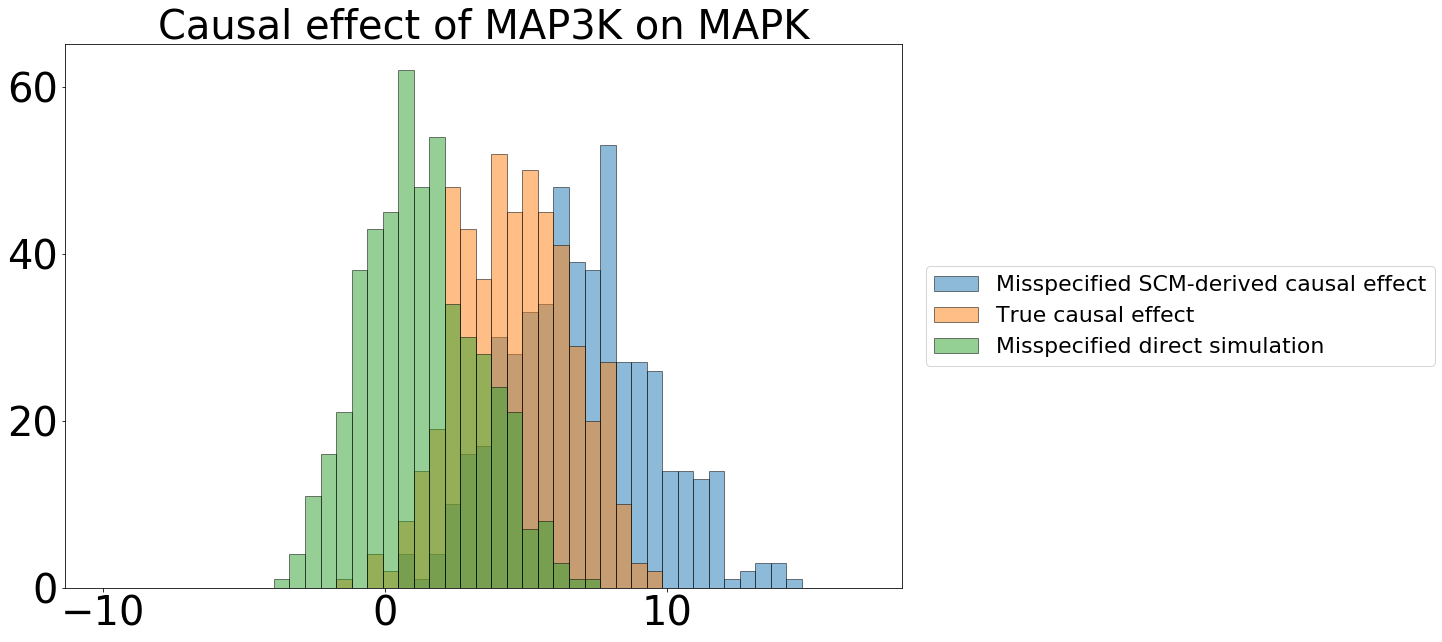

In [59]:
bins = np.linspace(-10, 17, 50)

fig = plt.figure(1,figsize=(15,10))
ax = fig.add_subplot(111)


plt.hist(misspeced_true, bins, alpha=0.5, label='Misspecified SCM-derived causal effect', edgecolor='black', linewidth=1)
plt.hist(out, bins, alpha=0.5, label='True causal effect', edgecolor='black', linewidth=1)
plt.hist(misspeced_false, bins, alpha=0.5, label='Misspecified direct simulation', edgecolor='black', linewidth=1)
plt.legend(loc='center right', bbox_to_anchor=(1.65, 0.5), fontsize=22)
plt.title("Causal effect of MAP3K on MAPK", fontsize=40)
plt.rc('xtick', labelsize=50)
plt.rc('ytick', labelsize=50)
plt.show()

### Median difference under misspecification

In [109]:
from statistics import median

true_scm_list = []
true_dyn_list = []

true_rates = {
        'raf_activate': 0.1,
        'raf_deactivate': 0.1,
        'mek_activate': 0.1,
        'mek_deactivate': 2.0,
        'erk_activate': 0.1,
        'erk_deactivate': 1.0
}

for i in tqdm(range(50)):
    misspeced_rates = {
        'raf_activate': pyro.sample('misspeced_', dist.Uniform(0.1,0.5)),
        'raf_deactivate': pyro.sample('misspeced_Mek', dist.Uniform(0.1,0.5)),
        'mek_activate': pyro.sample('misspeced_Mek', dist.Uniform(0.1,0.5)),
        'mek_deactivate': pyro.sample('misspeced_Mek', dist.Uniform(1.9,2.2)),
        'erk_activate': pyro.sample('misspeced_Mek', dist.Uniform(0.1,0.5)),
        'erk_deactivate': pyro.sample('misspeced_Mek', dist.Uniform(0.5,1.5))
    }
    
    true_mapk_scm = MAPK_SCM(true_rates, 
                    totals, 
                    spike_width=1.0) 
    true_obs = true_mapk_scm.model(noise)
    
    true_observation = {
        'Raf': float(true_obs[0]),
        'Mek': float(true_obs[1]),
        'Erk': float(true_obs[2])
    }
    
    mis_mapk_scm = MAPK_SCM(misspeced_rates, 
                    totals, 
                    spike_width=1.0)
    
    mis_obs = mis_mapk_scm.model(noise)
    
    misspeced_observation = {
        'Raf': float(mis_obs[0]),
        'Mek': float(mis_obs[1]),
        'Erk': float(mis_obs[2])
    }
    
    raf_intervention = {
        'Raf': 24.96818
    }
    
    true_ce = scm_erk_counterfactual(
        true_rates,
        totals,
        true_observation,
        raf_intervention,
        spike_width=1.0,
        svi=True
    )
    
    misspeced_true = scm_erk_counterfactual(
        misspeced_rates,
        totals,
        true_observation,
        raf_intervention,
        spike_width=1.0,
        svi=True
    )
    
    misspeced_false = scm_erk_counterfactual(
        misspeced_rates,
        totals,
        misspeced_observation,
        raf_intervention,
        spike_width=1.0,
        svi=True
    )
    
    true_scm_list.append(abs(median(true_ce) - median(misspeced_true)))
    true_dyn_list.append(abs(median(true_ce) - median(misspeced_false)))

In [114]:
print("True Vs. Misspecified SCM causal effect:", np.mean(true_scm_list))
print("True Vs. Misspecified dynamic model causal effect:", np.mean(true_dyn_list))

True Vs. Misspecified SCM causal effect: 0.34305877685546876
True Vs. Misspecified dynamic model causal effect: 1.0326355743408202


## IGF model

In [25]:
noise = {
        'N_SOS': dist.Normal(0., 1.),
        'N_Ras': dist.Normal(0., 1.),
        'N_PI3K': dist.Normal(0., 1.),
        'N_AKT': dist.Normal(0., 1.),
        'N_Raf': dist.Normal(0., 1.),
        'N_Mek': dist.Normal(0., 1.),
        'N_Erk': dist.Normal(0., 1.)
    }
misspeced_rates = {
  'SOS_activation_by_EGFR': .01,
  'SOS_activation_by_IGFR':.01,
  'SOS_deactivation':.5,
  'Ras_activation_by_SOS': .01,
  'Ras_deactivation':.5,
  'PI3K_activation_by_EGFR':.01,
  'PI3K_activation_by_IGFR':.01,
  'PI3K_activation_by_Ras':.01,
  'PI3K_deactivation':.5,
  'AKT_activation_by_PI3K':pyro.sample('misspeced_Ras', dist.Uniform(.05,.2)),
  'AKT_deactivation':.5,
  'Raf_activation_by_Ras':.01,
  'Raf_deactivation_by_AKT':.01,
  'Raf_deactivation_by_phosphotase':.3,
  'Mek_activation_by_Raf':.05,
  'Mek_deactivation': 0.5,
  'Erk_activation_by_Mek':.05,
  'Erk_deactivation':.5
}

rates = {
  'SOS_activation_by_EGFR': .01,
  'SOS_activation_by_IGFR':.01,
  'SOS_deactivation':.5,
  'Ras_activation_by_SOS':.01,
  'Ras_deactivation':.5,
  'PI3K_activation_by_EGFR':.01,
  'PI3K_activation_by_IGFR':.01,
  'PI3K_activation_by_Ras':.01,
  'PI3K_deactivation':.5,
  'AKT_activation_by_PI3K':.01,
  'AKT_deactivation':.5,
  'Raf_activation_by_Ras':.01,
  'Raf_deactivation_by_AKT':.01,
  'Raf_deactivation_by_phosphotase':.3,
  'Mek_activation_by_Raf':.05,
  'Mek_deactivation':.5,
  'Erk_activation_by_Mek':.05,
  'Erk_deactivation':.5
}

totals = {
        'SOS': 100.,
        'Ras': 100.,
        'PI3K': 100.,
        'AKT': 100.,
        'Raf': 100.,
        'Mek': 100.,
        'Erk': 100.
    }

gf_scm = GF_SCM(rates, totals, spike_width=1.0)
obs = gf_scm.model(noise)

observation = {
        'SOS': obs[0][0],
        'Ras': obs[0][1],
        'PI3K': obs[0][2],
        'AKT': obs[0][3],
        'Raf': obs[0][4],
        'Mek': obs[0][5],
        'Erk': obs[0][6]
}

gf_scm = GF_SCM(misspeced_rates, totals, spike_width=1.0)
obs = gf_scm.model(noise)

misspeced_observation = {
        'SOS': obs[0][0],
        'Ras': obs[0][1],
        'PI3K': obs[0][2],
        'AKT': obs[0][3],
        'Raf': obs[0][4],
        'Mek': obs[0][5],
        'Erk': obs[0][6]
}

ras_intervention = {
    'Ras': 15.0
}

In [26]:
igf_samples = np.array([np.array(gf_scm.model(noise)).flatten() for _ in range(1000)])

In [27]:
np.savetxt('igf_samples.txt', igf_samples, delimiter=',')

## True Counterfactual

In [28]:
out = scm_ras_erk_counterfactual(
        rates,
        totals,
        observation,
        ras_intervention,
        spike_width=1.0,
        svi=True
        )

# misspeced counterfactual with true data

In [29]:
misspeced_true = scm_ras_erk_counterfactual(
        misspeced_rates,
        totals,
        observation,
        ras_intervention,
        spike_width=1.0,
        svi=True
        )

## misspeced counterfactual with misspeced data

In [30]:
misspeced_false = scm_ras_erk_counterfactual(
        misspeced_rates,
        totals,
        misspeced_observation,
        ras_intervention,
        spike_width=1.0,
        svi=True
        )

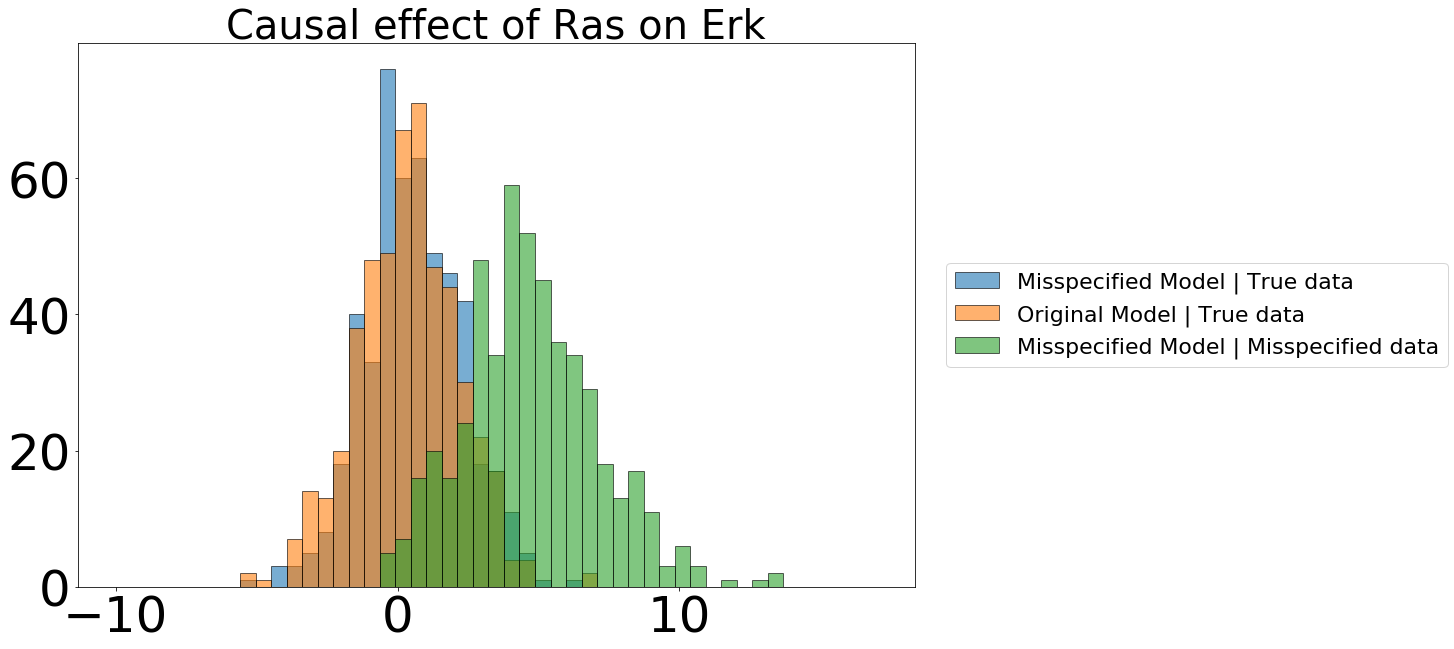

In [31]:
bins = np.linspace(-10, 17, 50)

fig = plt.figure(1,figsize=(15,10))
ax = fig.add_subplot(111)

plt.hist(misspeced_true, bins, alpha=0.6, label='Misspecified Model | True data', edgecolor='black', linewidth=1)
plt.hist(out, bins, alpha=0.6, label='Original Model | True data', edgecolor='black', linewidth=1)
plt.hist(misspeced_false, bins, alpha=0.6, label='Misspecified Model | Misspecified data', edgecolor='black', linewidth=1)
plt.legend(loc='center right', bbox_to_anchor=(1.65, 0.5), fontsize=22)
plt.title("Causal effect of Ras on Erk", fontsize=40)
plt.rc('xtick', labelsize=50)
plt.rc('ytick', labelsize=50)
plt.savefig('igf.png')

### Median difference under Misspecification

In [47]:
from statistics import median

noise = {
        'N_SOS': dist.Normal(0., 1.),
        'N_Ras': dist.Normal(0., 1.),
        'N_PI3K': dist.Normal(0., 1.),
        'N_AKT': dist.Normal(0., 1.),
        'N_Raf': dist.Normal(0., 1.),
        'N_Mek': dist.Normal(0., 1.),
        'N_Erk': dist.Normal(0., 1.)
    }

totals = {
        'SOS': 100.,
        'Ras': 100.,
        'PI3K': 100.,
        'AKT': 100.,
        'Raf': 100.,
        'Mek': 100.,
        'Erk': 100.
    }


true_scm_list = []
true_dyn_list = []

true_rates = {
  'SOS_activation_by_EGFR': .01,
  'SOS_activation_by_IGFR':.01,
  'SOS_deactivation':.5,
  'Ras_activation_by_SOS':.01,
  'Ras_deactivation':.5,
  'PI3K_activation_by_EGFR':.01,
  'PI3K_activation_by_IGFR':.01,
  'PI3K_activation_by_Ras':.01,
  'PI3K_deactivation':.5,
  'AKT_activation_by_PI3K':.01,
  'AKT_deactivation':.5,
  'Raf_activation_by_Ras':.01,
  'Raf_deactivation_by_AKT':.01,
  'Raf_deactivation_by_phosphotase':.3,
  'Mek_activation_by_Raf':.05,
  'Mek_deactivation':.5,
  'Erk_activation_by_Mek':.05,
  'Erk_deactivation':.5
}

for i in tqdm(range(50)):
    misspeced_rates = {
      'SOS_activation_by_EGFR': .01,
      'SOS_activation_by_IGFR':.01,
      'SOS_deactivation':.5,
      'Ras_activation_by_SOS': .01,
      'Ras_deactivation':.5,
      'PI3K_activation_by_EGFR':.01,
      'PI3K_activation_by_IGFR':.01,
      'PI3K_activation_by_Ras':.01,
      'PI3K_deactivation':.5,
      'AKT_activation_by_PI3K':pyro.sample('misspeced_Ras', dist.Uniform(.01,.1)),
      'AKT_deactivation':.5,
      'Raf_activation_by_Ras':.01,
      'Raf_deactivation_by_AKT':.01,
      'Raf_deactivation_by_phosphotase':.3,
      'Mek_activation_by_Raf':.05,
      'Mek_deactivation': 0.5,
      'Erk_activation_by_Mek':.05,
      'Erk_deactivation':.5
    }
    
    gf_scm = GF_SCM(true_rates, totals, spike_width=1.0)
    obs = gf_scm.model(noise)

    true_observation = {
            'SOS': obs[0][0],
            'Ras': obs[0][1],
            'PI3K': obs[0][2],
            'AKT': obs[0][3],
            'Raf': obs[0][4],
            'Mek': obs[0][5],
            'Erk': obs[0][6]
    }

    gf_scm = GF_SCM(misspeced_rates, totals, spike_width=1.0)
    obs = gf_scm.model(noise)

    misspeced_observation = {
            'SOS': obs[0][0],
            'Ras': obs[0][1],
            'PI3K': obs[0][2],
            'AKT': obs[0][3],
            'Raf': obs[0][4],
            'Mek': obs[0][5],
            'Erk': obs[0][6]
    }

    ras_intervention = {
        'Ras': 15.0
    }
    
    true_ce = scm_ras_erk_counterfactual(
            true_rates,
            totals,
            true_observation,
            ras_intervention,
            spike_width=1.0,
            svi=True
            )
    misspeced_true = scm_ras_erk_counterfactual(
        misspeced_rates,
        totals,
        true_observation,
        ras_intervention,
        spike_width=1.0,
        svi=True
    )
    
    misspeced_false = scm_ras_erk_counterfactual(
        misspeced_rates,
        totals,
        misspeced_observation,
        ras_intervention,
        spike_width=1.0,
        svi=True
    )
    
    true_scm_list.append(abs(median(true_ce) - median(misspeced_true)))
    true_dyn_list.append(abs(median(true_ce) - median(misspeced_false)))

A Jupyter Widget

In [48]:
print("True Vs. Misspecified SCM causal effect:", np.mean(true_scm_list))
print("True Vs. Misspecified dynamic model causal effect:", np.mean(true_dyn_list))

True Vs. Misspecified SCM causal effect: 7.563149
True Vs. Misspecified dynamic model causal effect: 92.55643
